<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
#@title Current Date
Today = '2021-09-22' #@param {type:"date"}


In [2]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "18213561 " #@param {type:"string"}
Student_full_name = "Pierluigi Riti" #@param {type:"string"}
#@markdown ---

In [3]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns # use Seaborn for the hotmap correlation
from sklearn.preprocessing import StandardScaler

In [6]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [7]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

## Training & Test Data

In [8]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# path to Google Drive
pathDrive = '/content/drive/MyDrive/Colab Notebooks/Etivity3/'

In [10]:
folderName = 'House_Dataset/'

syntPath = pathDrive+folderName
# training dataset: 
training_file = syntPath+"house_train.csv"
# test dataset: 
testing_file = syntPath+"house_test.csv"
# cost dataset: 
cost_file = syntPath+"true_price.csv"

# Exploratory Data Analysis(EDA)
Exploratory Data Analysis, EDA, involves looking and describing the data set from different point of views.

### Train dataset

In [11]:
# Exploratory Data Analysis(EDA)
# Load the data in the Pandas dataframe
dftrain = pd.read_csv(training_file)
# remove the first column of the dataset
dftrain = dftrain.drop(columns="ad_id", axis=1)

dftest = pd.read_csv(testing_file)
# remove the first column of the dataset
# dftest = dftest.drop(columns="ad_id", axis=1)

dfcost = pd.read_csv(cost_file)

In [12]:
# The shape function is used for show the number of observation and variable
# in the dataset
dftrain.shape

(2982, 16)

In [13]:
# show first data frame rows 
dftrain.head()

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [14]:
# let see some information about the dataset
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area                2982 non-null   object 
 1   bathrooms           2931 non-null   float64
 2   beds                2931 non-null   float64
 3   ber_classification  2305 non-null   object 
 4   county              2982 non-null   object 
 5   description_block   2982 non-null   object 
 6   environment         2982 non-null   object 
 7   facility            965 non-null    object 
 8   features            2982 non-null   object 
 9   latitude            2982 non-null   float64
 10  longitude           2982 non-null   float64
 11  no_of_units         59 non-null     float64
 12  price               2892 non-null   float64
 13  property_category   2982 non-null   object 
 14  property_type       2931 non-null   object 
 15  surface             2431 non-null   float64
dtypes: flo

In [15]:
# the function isna give us information about missing value in an observation
# the function sum() give us the total
dftrain.isna().sum()

area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

For better understand how to manipulate the data, I try to isolate the different feature with object and see the data contained inside

In [16]:
for label, contains in dftrain.items():
  if dftrain[label].dtypes == 'object':
    print("Label %s" % label)
    print(dftrain[label].tail(5))

Label area
2977    Ballsbridge
2978         Rialto
2979     Smithfield
2980        Foxrock
2981       Terenure
Name: area, dtype: object
Label ber_classification
2977    C3
2978    B2
2979    C3
2980    C3
2981    D2
Name: ber_classification, dtype: object
Label county
2977    Dublin
2978    Dublin
2979    Dublin
2980    Dublin
2981    Dublin
Name: county, dtype: object
Label description_block
2977    Sherry FitzGerald are delighted to present Apa...
2978    Property Team Patrick Moran is delighted to pr...
2979    Earnest estate agents are delighted to present...
2980    Janet Carroll Estate Agents are pleased to pre...
2981    ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...
Name: description_block, dtype: object
Label environment
2977    prod
2978    prod
2979    prod
2980    prod
2981    prod
Name: environment, dtype: object
Label facility
2977                                  NaN
2978                                  NaN
2979           Wired for Cable Television
2980    Parking,G

The column _features_ is a free text, we can't really encode that. The columns:

*  property_type
*  county
*  ber_classification
*  area

can be easily _Integer Encoded_ the other column can will be check later for understand if we can drop off 

In [17]:
# Generate descriptive statistics
dftrain.describe()

,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


# Data Description Analysis
The dataset show some colums as an _int64_, some as a _float64_, and some other as an _object_. Because we want to use a linear regression, the algorithm work better with Number, because of that I transform some data with an **_Integer encoding_**.
I apply the Integer Encoding on this features:


*   ber_classification
*   county
*   property_type
*   area

The feature _features_ and _description_block_, _facility_ are a free text box this make the feature difficult to encode,for this reason I drop the column, from the the train dataset and the test dataset.



Drop the colum in train and test

In [18]:
# drop the train
dftrain.drop('description_block', axis=1, inplace=True)
dftrain.drop('features', axis=1, inplace=True)
dftrain.drop('facility', axis=1, inplace=True)
# drop the test
dftest.drop('description_block', axis=1, inplace=True)
dftest.drop('features', axis=1, inplace=True)
dftest.drop('facility', axis=1, inplace=True)

# Integer Encoding

With the column dropped, let's use integer encoding on the other features:
*   ber_classification
*   county
*   property_type
*   area

For the Integer Encoding I need to identify the unique value for every column, I can do that with the function _unique()_ from Pandas

In [19]:
# Identify the unique value in the column for the ber_classification
dftrain["ber_classification"].unique()

array([nan, 'A3', 'A2', 'E2', 'G', 'C1', 'F', 'C2', 'C3', 'D2', 'D1',
       'B2', 'E1', 'SINo666of2006exempt', 'B3', 'B1', 'A1'], dtype=object)

In [20]:
# Create the mapper for the ber_classification
ber_mapper = {
    "A1":1,
    "A2":2,
    "A3":3,
    "B1":4,
    "B2":5,
    "B3":6,
    "C1":7,
    "C2":8,
    "C3":9,
    "D1":10,
    "D2":11,
    "E1":12,
    "E2":13,
    "F":14,
    "G":15,
    "SINo666of2006exempt":16
}
# apply the transformer on the train dataset and the test dataset
dftrain["ber_classification"] = dftrain["ber_classification"].replace(ber_mapper)
dftest["ber_classification"] = dftest["ber_classification"].replace(ber_mapper)

In [21]:
# Identify the unique value for the county
dftrain["county"].unique()

array(['Dublin'], dtype=object)

In [22]:
# Create the mapper for the county
county_mapper = {
    "Dublin":1
}
# apply the transformer on the train dataset and the test dataset
dftrain["county"] = dftrain["county"].replace(county_mapper)
dftest["county"] = dftest["county"].replace(county_mapper)

In [23]:
# Identify the unique value for the property_type
dftrain["property_type"].unique()

array([nan, 'detached', 'semi-detached', 'apartment', 'terraced', 'site',
       'bungalow', 'townhouse', 'end-of-terrace', 'duplex', 'studio'],
      dtype=object)

In [24]:
# Create the mapper for the property_type
property_type_mapper = {
    "nan":1,
    "detached":2,
    "semi-detached":3,
    "apartment":4,
    "terraced":5,
    "site":6,
    "bungalow":7,
    "townhouse":8,
    "end-of-terrace":9,
    "duplex":10,
    "studio":11
}
# apply the transformer on the train dataset and the test dataset
dftrain["property_type"] = dftrain["property_type"].replace(property_type_mapper)
dftest["property_type"] = dftest["property_type"].replace(property_type_mapper)

In [25]:
# Identify the unique value for the Area
dftrain["area"].unique()

array(['Portmarnock', 'Lucan', 'Rathfarnham', 'Balbriggan', 'Foxrock',
       'Blackrock', 'Templeogue', 'Ballyboughal', 'Ballycullen',
       'Cabinteely', 'Glasnevin', 'Skerries', 'Clongriffin', 'Clonee',
       'Killiney', 'Newcastle', 'Donabate', 'Dublin 2', 'Lusk',
       'Clondalkin', 'Rathgar', 'Glenageary', 'Goatstown',
       'Dun Laoghaire', 'Howth', 'Castleknock', 'Citywest', 'Malahide',
       'Swords', 'Rush', 'Shankill', 'Stepaside', 'Donaghmede',
       'Dublin 4', 'Baldoyle', 'Ranelagh', 'Carrickmines', 'Rathmichael',
       'Loughshinny', 'Finglas', 'Dublin 1', 'Ballsbridge', 'Sandycove',
       'Dalkey', 'Dublin 8', 'Booterstown', 'Ballymun', 'Navan Road (D7)',
       'Cabra', 'Garristown', 'Rialto', 'Drumcondra', 'Clontarf',
       'Dundrum', 'Donnybrook', 'Santry', 'Blanchardstown', 'Sandyford',
       'Palmerstown', 'Sandymount', 'Terenure', 'Crumlin', 'Saggart',
       'Mulhuddart', 'Whitehall', 'Walkinstown', 'Christchurch',
       'Clonskeagh', 'Phibsborough', '

In [26]:
# Create the mapper for the area
area_mapper = {
    "Portmarnock":1,"Lucan":2,"Rathfarnham":3,"Balbriggan":4,"Foxrock":5,
    "Blackrock":6,"Templeogue":7,"Ballyboughal":8,"Ballycullen":9,"Cabinteely":10, 
    "Glasnevin":11,"Skerries":12,"Clongriffin":13,"Clonee":14,"Killiney":15, 
    "Newcastle":16,"Donabate":17,"Dublin 2":18,"Lusk":19,"Clondalkin":20, 
    "Rathgar": 21, "Glenageary": 22, "Goatstown": 23,"Dun Laoghaire": 24,"Howth": 25, 
    "Castleknock": 26,"Citywest": 27,"Malahide": 28,"Swords": 29,"Rush": 30,
    "Shankill": 31,"Stepaside": 32,"Donaghmede": 33,"Dublin 4": 34,"Baldoyle": 35, 
    "Ranelagh": 36,"Carrickmines": 37,"Rathmichael": 38,"Loughshinny": 39,"Finglas": 40, 
    "Dublin 1": 41,"Ballsbridge": 42,"Sandycove": 43,"Dalkey": 44,"Dublin 8": 45,
    "Booterstown": 46,"Ballymun": 47,"Navan Road (D7)": 48,"Cabra": 49,"Garristown": 50, 
    "Rialto": 51,"Drumcondra": 52,"Clontarf": 53,"Dundrum": 54,"Donnybrook": 55, 
    "Santry": 56,"Blanchardstown": 57,"Sandyford": 58,"Palmerstown": 59,"Sandymount": 60, 
    "Terenure": 61,"Crumlin": 62,"Saggart": 63,"Mulhuddart": 64,"Whitehall": 65, 
    "Walkinstown": 66,"Christchurch": 67,"Clonskeagh": 68,"Phibsborough": 69,"Clonsilla": 70, 
    "Ringsend": 71,"Churchtown": 72,"Dublin 7": 73,"Tyrrelstown": 74,"Ballybrack": 75,
    "Mount Merrion": 76,"Rathmines": 77,"The Ward": 78,"Kilternan": 79,"Sutton": 80,
    "Harold's Cross": 81,"Clarehall": 82,"Firhouse": 83,"Portobello": 84,"Killester": 85, 
    "Monkstown": 86,"Kilmore": 87,"Milltown": 88,"Tallaght": 89,"Ballymount": 90, 
    "Loughlinstown": 91,"Clonshaugh": 92,"East Wall": 93,"Grand Canal Dock": 94,"Leopardstown": 95, 
    "Artane": 96,"Kinsealy": 97,"Poppintree": 98,"Kimmage": 99,"Knocklyon":100, 
    "Dolphin's Barn": 101,"Raheny": 102,"Naul": 103,"Inchicore": 104,"Adamstown": 105, 
    "IFSC": 106,"Kilmainham": 107,"Darndale": 108,"Kilnamanagh": 109,"Rathcoole": 110, 
    "Fairview": 111, "Ard Na Greine": 112,"North Circular Road": 113, "Beaumont": 114, 
    "Temple Bar": 115,"Drimnagh": 116,"Coolock": 117, "Donnycarney": 118,"Stoneybatter": 119, 
    "Ballyfermot": 120,"Balgriffin": 121, "North Strand": 122, "Smithfield": 123, 
    "Ballinascorney": 124,"Coolmine": 125, "Sallynoggin": 126, "Ongar": 127, "Marino": 128, 
    "Dartry": 129,"Ballinteer": 130, "Hartstown": 131, "Ashtown": 132, "Kilmacud": 133, 
    "Carpenterstown": 134,"Park West": 135, "Irishtown": 136, "Chapelizod": 137, 
    "Balrothery": 138, "Ballybough": 139,"Greenhills": 140, "Perrystown": 141, 
    "Brittas": 142, "Bluebell": 143, "Kingswood": 144, "The Coombe": 145, "Edenmore": 146, 
    "Merrion": 147, "Oldbawn": 148, "Deansgrange": 149, "Bayside": 150, "Windy Arbour": 151, 
    "Cherry Orchard":152,"Islandbridge":153,"South Circular Road":154,"Kiltipper":155,
    "St Margaret's":156
}
# apply the transformer on the train dataset and the test dataset
dftrain['area'] = dftrain['area'].replace(area_mapper)
dftest['area'] = dftest['area'].replace(area_mapper)

In [27]:
dftrain['environment'].unique()

array(['prod'], dtype=object)

In [28]:
# Create the mapper for the property category
environment_mapper = {
    "prod":0
}
# apply the transformer on the train dataset and the test dataset
dftrain['environment'] = dftrain['environment'].replace(environment_mapper)
dftest['environment'] = dftest['environment'].replace(environment_mapper)

In [29]:
dftrain['property_category'].unique()

array(['new_development_parent', 'sale'], dtype=object)

In [30]:
# Create the mapper for the environment
property_category_mapper = {
    "new_development_parent":0,
    "sale":1
}
# apply the transformer on the train dataset and the test dataset
dftrain['property_category'] = dftrain['property_category'].replace(property_category_mapper)
dftest['property_category'] = dftest['property_category'].replace(property_category_mapper)

In [31]:
dftrain.tail(5)

,area,bathrooms,beds,ber_classification,county,environment,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,42,2.0,2.0,9.0,1,0,53.338738,-6.237199,NaN,415000.0,1,4.0,56.0
2978,51,1.0,3.0,5.0,1,0,53.335793,-6.294268,NaN,485000.0,1,5.0,101.0
2979,123,1.0,2.0,9.0,1,0,53.346098,-6.276856,NaN,299000.0,1,4.0,55.6
2980,5,2.0,3.0,9.0,1,0,53.273518,-6.178500,NaN,495000.0,1,9.0,97.0
2981,61,2.0,3.0,11.0,1,0,53.310073,-6.325158,NaN,525000.0,1,3.0,129.3


In [32]:
dftrain.isna().sum()

area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
environment              0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

The value of the NaN is the same for _bathrooms_ and _beds_ and it is very low, if there is no _price_ there is no data to compare. Let's remove some value NaN value from the dataset

In [33]:
dftrain.dropna(inplace=True,subset=['beds','bathrooms','price'])

In [34]:
dftrain.isna().sum()

area                     0
bathrooms                0
beds                     0
ber_classification     608
county                   0
environment              0
latitude                 0
longitude                0
no_of_units           2885
price                    0
property_category        0
property_type            0
surface                490
dtype: int64

The column _no_of_units_ have 2885 value NaN on 2982 value, the column can be drop because doesn't add any value

In [35]:
dftrain.drop('no_of_units', axis=1, inplace=True)
dftest.drop('no_of_units', axis=1, inplace=True)

There is the remain value from _surface_ and ber_classification, I fill this value with the _median_ value for the field.

In [36]:
# Fill the train dataset
dftrain['ber_classification'].fillna(dftrain['ber_classification'].median(), inplace=True)
dftrain['surface'].fillna(dftrain['surface'].median(), inplace=True)
# Fill the test dataset
dftest['ber_classification'].fillna(dftest['ber_classification'].median(), inplace=True)
dftest['surface'].fillna(dftest['surface'].median(), inplace=True)

In [37]:
dftrain.isna().sum()

area                  0
bathrooms             0
beds                  0
ber_classification    0
county                0
environment           0
latitude              0
longitude             0
price                 0
property_category     0
property_type         0
surface               0
dtype: int64

The dataset is not clean, let see if the test dataset is clean as well

In [38]:
dftest.isna().sum()

ad_id                 0
area                  0
bathrooms             0
beds                  0
ber_classification    0
county                0
environment           0
latitude              0
longitude             0
property_category     0
property_type         0
surface               0
dtype: int64

The test dataset is clean as well, we are now ready to proced with the Linear Regression

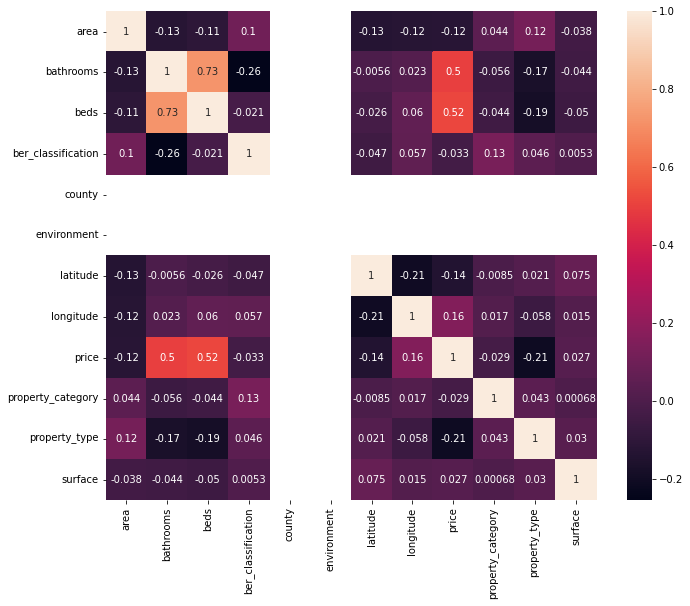

In [39]:
# define the heat-map correlation
fig, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(dftrain.corr(), annot=True)

plt.show()

The correlation map, show the field more correlated with the _price_, the feature are:


*   bathrooms
*   beds

We use this features for define our Linear Regression



In [40]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
# X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

### Expected Cost dataset

In [41]:
dfcost.head()

,Id,Expected
0,12373510,875000.0
1,12422623,355000.0
2,12377408,440000.0
3,12420093,425000.0
4,12417338,265000.0


In [42]:
dfcost.isna().sum()

Id          0
Expected    0
dtype: int64

In [43]:
# Generate descriptive statistics
dfcost.describe()

,Id,Expected
count,5.000000e+02,5.000000e+02
mean,1.231695e+07,5.810356e+05
std,1.485832e+05,6.009194e+05
min,1.130615e+07,8.500000e+04
25%,1.228617e+07,2.950000e+05
50%,1.237964e+07,4.250000e+05
75%,1.240544e+07,5.950000e+05
max,1.242809e+07,5.750000e+06


# PIECEWISE REGRESSION

## Full Model

In [44]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

featrain = ['beds','bathrooms','price']
# dropna: remove missing values
df_subset_train = dftrain[featrain].dropna(axis=0)

featest = ['beds','bathrooms']
df_subset_test  =  dftest[featest].dropna(axis=0)

# cost
dfcost = dfcost[dfcost.index.isin(df_subset_test.index)]

In [45]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

NameError: ignored

In [ ]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

## Clustering

### Full Model

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)


### Clusters

In [ ]:
# train clusters



In [ ]:
# test clusters


## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])



##Simulations

### Only Cluster 0

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY